In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from wordcloud import WordCloud
import wordcloud
from textblob import TextBlob
import requests
import fasttext
import datetime
import json
import tweepy as tw
import os
import itertools
import re
import emoji
import math
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression       # linear regression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence

In [4]:
from datetime import datetime, timedelta

diapason = ["2021-05-01", "2022-05-15"]
start, end = [datetime.fromisoformat(d) for d in diapason]

output = [[start.date()+timedelta(d), start.date()+timedelta(d+1)] for d in range((end-start).days + 2)]
output[0][0], output[-1][-1] = start, end

output = [(l[0].strftime('%Y-%m-%d'), l[1].strftime('%Y-%m-%d')) for l in output]

daily_bayc_df=[]

for i in range(len(output)):
    tweet_count = 300
    text_query = "BAYC"
    since_date = output[i][0]
    until_date = output[i][1]
    os.system('snscrape --jsonl --max-results {} --since {} twitter-search "{} until:{}"> bayc_data.json'.format(tweet_count, since_date, text_query, until_date))
    # Reads the json generated from the CLI command above and creates a pandas dataframe
    bayc_data = pd.read_json('bayc_data.json', lines=True)
    daily_bayc_df.append(bayc_data)

In [279]:
mystring=("Hey we'd like to deliver you guys a super exhausting presentation :-)" 
          "Feel free to take a good nap🥳.@Patrick https://comp4450")
sid_obj = SentimentIntensityAnalyzer()
sentiment_dict = sid_obj.polarity_scores(mystring)
sentiment_dict

{'neg': 0.076, 'neu': 0.459, 'pos': 0.465, 'compound': 0.9136}

In [337]:
def influence_weight(Metric):
    if (Metric[0]+Metric[1])==0:
        return 1
    else:
        return np.sqrt(Metric[0]+Metric[1])
#Clean data
def clean_data(text):
    text=re.sub(r'@[A-Za-z0-9]+','',text)#Remove mention
    text=re.sub(r'[A-Za-z0-9]@+','',text)
    text=re.sub(r'#[A-Za-z0-9]+','',text) #Remove hashtag
    text=re.sub(r'RT[\s]+','',text) #Remove retweet
    text=re.sub(r'\w+:\/\/\S+','',text) #Remove hyperlink
    text=re.sub("[\.\,\!\?\:\;\-\=]", " ", text) #Remove all punctuations
    text=text.lower() #Avoid Case sensitive
    text = re.sub('[\s]+', ' ', text)# Replace multiple white space with one
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) #Misspelling
    text = ' '.join(((emoji.demojize(text)).replace(":"," ")).split())
    return text

def convert_contraction(tweet):
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    tweet = str(tweet).replace("’","'")
    words = str(tweet).split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    tweet = " ".join(reformed)
    return tweet

def convert_emoticons(text):
    SMILEY = EMOTICONS_EMO
    words = str(text).split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    text = " ".join(reformed)
    return text

#Duplicate and NAN
def drop_duplicate(data):
    data=data.drop_duplicates(subset=['content'],keep='first',inplace=True)
def drop_na(data):
    data=data.dropna(axis=0,subset=['content'],inplace=True)
    
#Stop words
sw = stopwords.words('english') #you can adjust the language as you desire
sw.remove("not")
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in sw]
    return (" ").join(tokens_without_sw)
def compound_score(text):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict['compound']

classifier = TextClassifier.load('en-sentiment')
def flair_score(text):
    sentence=Sentence(text)
    classifier.predict(sentence)
    score = sentence.labels[0].score
    return score
def flair_sentiment(text):
    sentence=Sentence(text)
    classifier.predict(sentence)
    sentiment = sentence.labels[0].value
    return sentiment


2022-05-25 23:20:53,239 loading file /Users/coppersa/.flair/models/sentiment-en-mix-distillbert_4.pt


In [109]:
### Vader ###
sentiment_score_final=[]
for i in range(len(daily_bayc_df)-1):
    daily_bayc_df[i]['Influence']=daily_bayc_df[i]['likeCount']+daily_bayc_df[i]['replyCount']
    daily_bayc_df[i].loc[daily_bayc_df[i]['Influence']==0,['Influence']]=1
    daily_bayc_df[i]['content']=daily_bayc_df[i]['content'].apply(clean_data)
    daily_bayc_df[i]['content']=daily_bayc_df[i]['content'].apply(convert_emoticons)
    daily_bayc_df[i]['content']=daily_bayc_df[i]['content'].apply(convert_contraction)
    daily_bayc_df[i]['content']=daily_bayc_df[i]['content'].apply(remove_stopwords)
    drop_duplicate(daily_bayc_df[i])
    drop_na(daily_bayc_df[i])
    daily_bayc_df[i]=daily_bayc_df[i].drop(daily_bayc_df[i][daily_bayc_df[i].content==""].index)
    daily_bayc_df[i]['CompoundScore']=daily_bayc_df[i]['content'].apply(compound_score)
    daily_bayc_df[i]['Finalscore']=daily_bayc_df[i]['Influence']*daily_bayc_df[i]['CompoundScore']
    sentiment_score_final.append(np.sum(daily_bayc_df[i]['Finalscore'].values)/daily_bayc_df[i].shape[0])

In [448]:
len(sentiment_score_final)

93

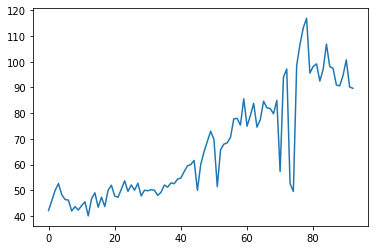

In [69]:
plt.plot(np.flip(bayc_floor[85:178]['Daily_Price'].values))

In [228]:
bayc_floor=pd.read_csv('Bayc Floor Price.csv')
bayc_floor.rename(columns={"Floor Price Ξ":"Daily_Price"},inplace=True)
floor_arr=bayc_floor[85:178]['Daily_Price'].values
ss=StandardScaler()
normalized=ss.fit_transform(floor_arr.reshape(-1,1))
floor_list=[]
for i in range(normalized.shape[0]):
    floor_list.append(normalized[i][0])
Corr_dict={"Score":sentiment_score_final,"FloorPrice":floor_list}
corr_df=pd.DataFrame(Corr_dict)
print(corr_df.corr())

               Score  FloorPrice
Score       1.000000   -0.166239
FloorPrice -0.166239    1.000000


In [326]:
flair_bayc_df=daily_bayc_df.copy()

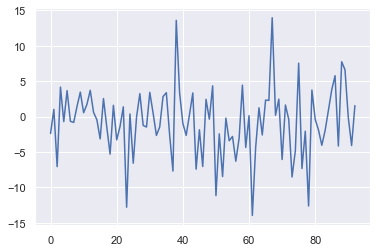

In [447]:
plt.plot(flair_score_final)

In [337]:
## Flair ###
for k in range(0,93):
    flair_bayc_df[k]['Flair_Sentiment']=flair_bayc_df[k]['content'].apply(flair_sentiment)
    flair_bayc_df[k]['Flair_Score']=flair_bayc_df[k]['content'].apply(flair_score)
    flair_bayc_df[k].loc[flair_bayc_df[k]['Flair_Sentiment']=='NEGATIVE',['Flair_Score']]=-flair_bayc_df[k]['Flair_Score']
    flair_bayc_df[k]['Finalscore']=daily_bayc_df[k]['Influence']*daily_bayc_df[k]['Flair_Score']
    flair_score_final.append(np.sum(flair_bayc_df[k]['Finalscore'].values)/flair_bayc_df[k].shape[0])

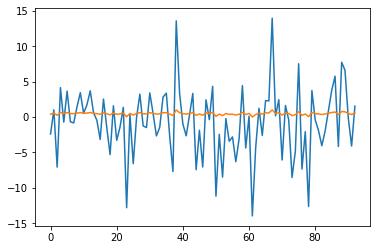

In [364]:
plt.plot(flair_score_final)
import numpy as np
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(np.array(flair_score_final).reshape(-1,1))


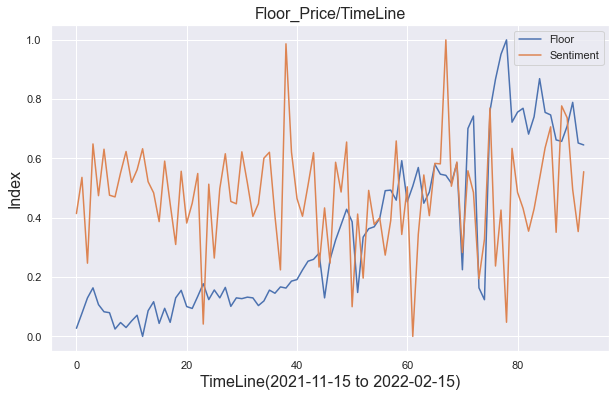

In [444]:

sns.set(font_scale=1.0)
floooor=np.array(np.flip(bayc_floor[85:178]['Daily_Price'].values)).reshape(-1,1)
floor_minmax=min_max_scaler.fit_transform(floooor)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(floor_minmax,label='Floor')
plt.plot(np.squeeze(X_train_minmax),label='Sentiment')
ax.set_xlabel('TimeLine(2021-11-15 to 2022-02-15)',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.set_ylabel('Index',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.set_title('Floor_Price/TimeLine',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.legend()
plt.show()

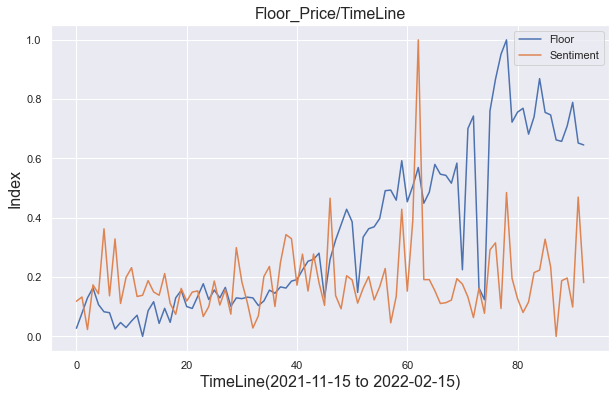

In [453]:
Vader_train_minmax = min_max_scaler.fit_transform(np.array(sentiment_score_final).reshape(-1,1))
sns.set(font_scale=1.0)
floooor=np.array(np.flip(bayc_floor[85:178]['Daily_Price'].values)).reshape(-1,1)
floor_minmax=min_max_scaler.fit_transform(floooor)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(floor_minmax,label='Floor')
plt.plot(np.squeeze(Vader_train_minmax),label='Sentiment')
ax.set_xlabel('TimeLine(2021-11-15 to 2022-02-15)',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.set_ylabel('Index',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.set_title('Floor_Price/TimeLine',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.legend()
plt.show()


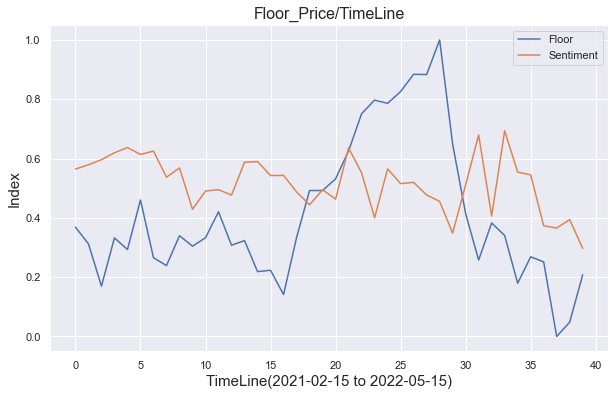

In [281]:
start = datetime.datetime.strptime("11-04-2022", "%d-%m-%Y")
end = datetime.datetime.strptime("11-05-2022", "%d-%m-%Y")
retime= [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
sns.set(font_scale=1.0)
floooor=np.array(np.flip(bayc_floor[0:40]['Daily_Price'].values)).reshape(-1,1)
floor_minmax=min_max_scaler.fit_transform(floooor)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(floor_minmax,label='Floor')
plt.plot(Bayc_2022[0:40],label='Sentiment')
ax.set_xlabel('TimeLine(2021-02-15 to 2022-05-15)',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax.set_ylabel('Index',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax.set_title('Floor_Price/TimeLine',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.legend()
plt.show()


In [124]:
ape2022=ape2022[['date','likeCount','replyCount','CompoundScore']]

In [130]:
ape2022.drop(ape2022[ape2022["likeCount"]=="http://twitter.com/download/iphone"].index,inplace=True)
ape2022["likeCount"] = pd.to_numeric(ape2022["likeCount"])
ape2022["replyCount"] = pd.to_numeric(ape2022["replyCount"])
ape2022["CompoundScore"] = pd.to_numeric(ape2022["CompoundScore"])

In [133]:
def dateparse(date):
    return date[0:10]
ape2022['date']=ape2022['date'].apply(dateparse)

In [142]:
ape2022['AltInfluence']=np.sqrt(ape2022['likeCount']+ape2022['replyCount'])
ape2022.loc[ape2022['AltInfluence']==0,['AltInfluence']]=1
ape2022['AltFinalscore']=ape2022['AltInfluence']*ape2022['CompoundScore']

In [143]:
altfinalscore=(ape2022.groupby(['date']).mean())['AltFinalscore'].values

len(altfinalscore)

90

           Sentiment     Floor
Sentiment   1.000000 -0.313252
Floor      -0.313252  1.000000


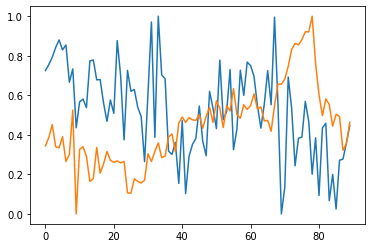

In [144]:
altfinalscore=list(altfinalscore)
import numpy as np
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
Alt_train_minmax = min_max_scaler.fit_transform(np.array(altfinalscore).reshape(-1,1))

floooor=np.array(np.flip(bayc_floor[0:90]['Daily_Price'].values)).reshape(-1,1)
floor_minmax=min_max_scaler.fit_transform(floooor)

plt.plot(Alt_train_minmax)
plt.plot(floor_minmax)
Corr_dict={'Sentiment':list(np.squeeze(Alt_train_minmax)),'Floor':list(np.squeeze(floor_minmax))}
dfcorr=pd.DataFrame(Corr_dict)
print(dfcorr.corr(method='pearson'))

In [332]:
convert_contraction(ape2000['content'][0])
convert_contraction(ape2000['content'][1])
ape2000.loc[:,'content']

0         everyone fudding 'm pretty sure bought previou...
1                 _bayc1 “ bayc tribute ” mean complete rip
2         well 've said crypto punks xcopy dmitri fidenz...
3         jrny family still remember day got bayc announ...
4                                clone x possibly pass bayc
                                ...                        
123290    grandpa ape country club owner slim612 fire ra...
123291                                                  see
123292    creators bayc mayc punks otherdeed even made a...
123293                                    bayc mayc holders
123294                                                  NaN
Name: content, Length: 123295, dtype: object

           Sentiment     Floor
Sentiment   1.000000 -0.038478
Floor      -0.038478  1.000000


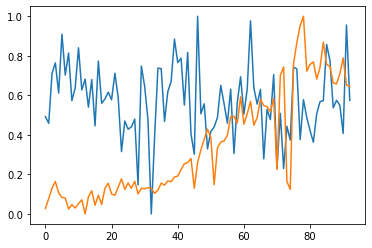

In [118]:
newfinalscore=list(newfinalscore)
import numpy as np
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
Vader_train_minmax = min_max_scaler.fit_transform(np.array(newfinalscore).reshape(-1,1))

floooor=np.array(np.flip(bayc_floor[85:178]['Daily_Price'].values)).reshape(-1,1)
floor_minmax=min_max_scaler.fit_transform(floooor)

plt.plot(Vader_train_minmax)
plt.plot(floor_minmax)

Corr_dict={'Sentiment':list(np.squeeze(Vader_train_minmax)),'Floor':list(np.squeeze(floor_minmax))}
dfcorr=pd.DataFrame(Corr_dict)
print(dfcorr.corr(method='pearson'))

In [15]:
def dateconvert(date):
    return date[0:10]
ape2021['date']=ape2021['date'].apply(dateconvert)

In [52]:
final_list=ape2021.groupby('date').count().values[:-1]
list(np.squeeze(final_list))
ape2021["Finalscore"] = pd.to_numeric(ape2021["Finalscore"])

In [9]:
Bayc_2022=np.genfromtxt('bayc_txt.txt')

In [8]:
Bayc_2021=sentiment_score_final
Bayc_2022=list(Bayc_2022)

NameError: name 'sentiment_score_final' is not defined

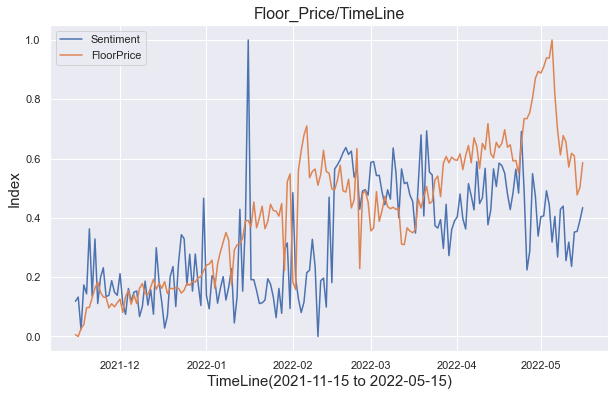

In [568]:
Bayc_whole=list(np.squeeze(Vader_train_minmax))+Bayc_2022
Bayc_whole
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(Retime,Bayc_whole,label='Sentiment')
floor_whole=(bayc_floor[0:183]["Daily_Price"].values).reshape(-1,1)
normalized_whole=np.flip(min_max_scaler.fit_transform(floor_whole))
plt.plot(Retime,normalized_whole,label='FloorPrice')
Correlation={'Sentiment':Bayc_whole,'Price':list(np.squeeze(normalized_whole))}
dfcorr=pd.DataFrame(Correlation)
ax.set_xlabel('TimeLine(2021-11-15 to 2022-05-15)',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax.set_ylabel('Index',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax.set_title('Floor_Price/TimeLine',fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.legend()
plt.show()

start = datetime.datetime.strptime("15-11-2021", "%d-%m-%Y")
end = datetime.datetime.strptime("17-05-2022", "%d-%m-%Y")
Retime= [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

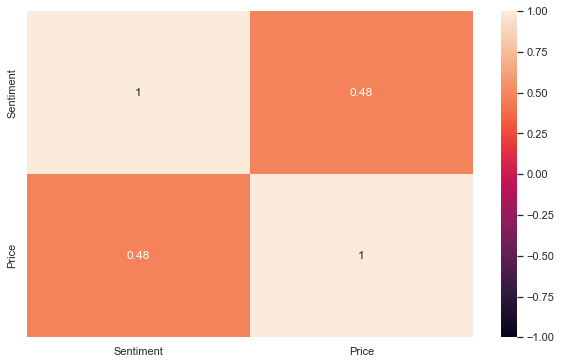

In [566]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(font_scale=1.0)
sns.heatmap(dfcorr.corr(),vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
bayc_floor=pd.read_csv('Bayc Floor Price.csv')
bayc_floor.rename(columns={"Floor Price Ξ":"Daily_Price"},inplace=True)
newarr=bayc_floor[0:85]["Daily_Price"].values
normalized_arr= min_max_scaler.fit_transform(newarr.reshape(-1,1))
# plt.plot(np.flip(normalized_arr))
# plt.plot(sentiment_3m_df['sentiment_score'])
normalized_arr=np.squeeze(np.flip(normalized_arr))
plot_dict={'Normalized':normalized_arr[40:80],'Score':sentiment_3m_df['sentiment_score'].values[35:75],'TimeLine':range(40,80)}
plot_df=pd.DataFrame(plot_dict)
sns.lineplot(data=plot_df,x='TimeLine',y='Normalized')
sns.lineplot(data=plot_df,x='TimeLine',y='Score')

Text(0.5, 1.0, 'Bayc Daily Log Returns(Log scale)')

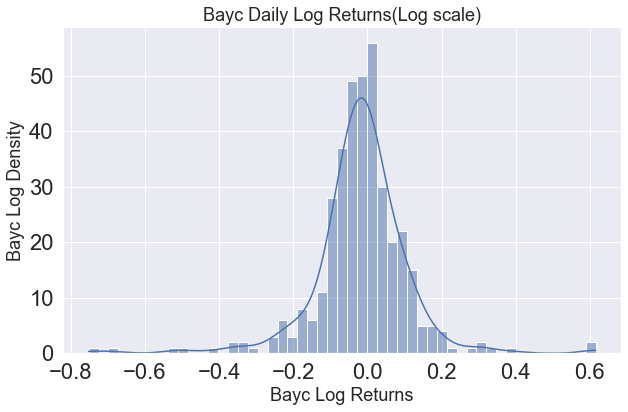

In [415]:
# reference:https://towardsdatascience.com/cryptocurrency-analysis-with-python-log-returns-f9c198a27884
# Confirm 
def logreturn_calc(Dataset):
    Dataset['Log_returns']=np.log(Dataset['Daily_Price'])-np.log(Dataset['Daily_Price'].shift(1))

bayc_floor=pd.read_csv('Bayc Floor Price.csv')
bayc_floor.rename(columns={"Floor Price Ξ":"Daily_Price"},inplace=True)

ETH_Daily=pd.read_csv('ETHDaily.csv')
ETH_Daily.set_index('time',inplace=True)
ETH_Daily.sort_index(axis=0,ascending=False,inplace=True)
ETH_Daily.rename(columns={"avg(price)":"Daily_Price"},inplace=True)

SP_Daily=pd.read_csv('S&P.csv')
SP_Daily.rename(columns={"Close/Last":"Daily_Price"},inplace=True)

Azuki=pd.read_csv('Azuki.csv')
Azuki.rename(columns={"Floor Price Ξ":"Daily_Price"},inplace=True)

for df in [bayc_floor,ETH_Daily,SP_Daily,Azuki]:
    logreturn_calc(df)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(bayc_floor.iloc[:,-1][1:],kde=True,palette='Red')
ax.set_xlabel('Bayc Log Returns',fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_ylabel('Bayc Log Density',fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_title('Bayc Daily Log Returns(Log scale)',fontdict={'fontsize': 18, 'fontweight': 'medium'})

# fig, ax = plt.subplots(figsize=(10, 6))
# sns.histplot(ETH_Daily.iloc[:,-1],kde=True,label="ETH",color='darkorange')
# sns.histplot(SP_Daily.iloc[:,-1],kde=True,label="S&P",color='skyblue')
# ax.set_xlabel('Log Returns',fontdict={'fontsize': 18, 'fontweight': 'medium'})
# ax.set_ylabel('Log Density',fontdict={'fontsize': 18, 'fontweight': 'medium'})
# ax.set_title('Daily Log Returns(Log scale)',fontdict={'fontsize': 18, 'fontweight': 'medium'})
# ax.legend()
# plt.show()

# fig, ax = plt.subplots(figsize=(10, 6))
# sns.kdeplot(bayc_floor.iloc[:,-1][0:377],shade=True,label="Bayc",multiple='stack')
# sns.kdeplot(ETH_Daily.iloc[:,-1][0:377],shade=True,label="ETH")
# sns.kdeplot(SP_Daily.iloc[:,-1][0:377],shade=True,label="S&P")
# ax.set_xlabel('Log Returns',fontdict={'fontsize': 18, 'fontweight': 'medium'})
# ax.set_ylabel('Log Density',fontdict={'fontsize': 18, 'fontweight': 'medium'})
# ax.set_title('Daily Log Returns(Log scale)',fontdict={'fontsize': 18, 'fontweight': 'medium'})

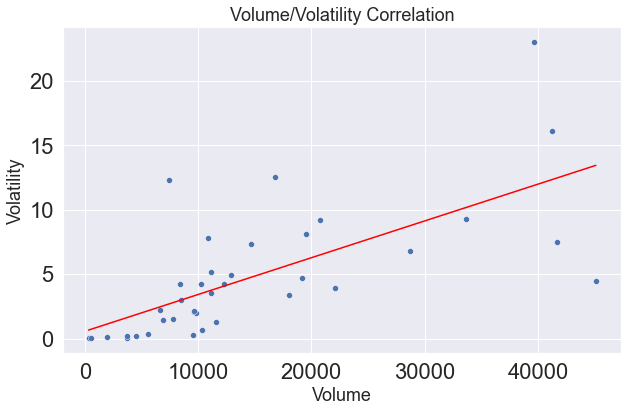

In [432]:
baycdata = pd.read_csv("Bayc Floor Price.csv")
baycdata['Day'] = pd.to_datetime(baycdata['Day'])
res=baycdata.resample('10D', on='Day').agg({'Floor Price Ξ':'std', 'Volume Ξ':'sum'})
res.rename(columns={"Floor Price Ξ": "Volatility", "Volume Ξ": "Volume"},inplace=True)
newdf=res[['Volume','Volatility']]
lr = LinearRegression()
model=lr.fit(newdf['Volume'].values.reshape(-1,1),newdf['Volatility'].values)
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=res,x='Volume',y='Volatility', palette="orange")
b0 = model.intercept_
b1 = model.coef_[0]
x_range = [newdf['Volume'].min(), newdf['Volume'].max()]                      # get the bounds for x
y_range = [b0+b1*x_range[0], b0+b1*x_range[1]]    # get the bounds for y
plt.plot(x_range, y_range, c="red")
ax.set_xlabel('Volume',fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_ylabel('Volatility',fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_title('Volume/Volatility Correlation',fontdict={'fontsize': 18, 'fontweight': 'medium'})
plt.show()

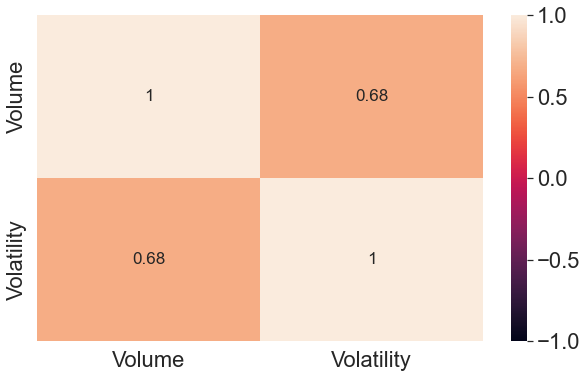

In [430]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(font_scale=1.0)
sns.heatmap(newdf.corr(),vmin=-1, vmax=1, annot=True,annot_kws={"size":17})
plt.show()

In [259]:
# self defined contractions
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }

In [260]:
# reference:https://github.com/MartinBeckUT/TwitterScraper/blob/master/snscrape/cli-with-python/snscrape-python-cli.ipynb
tweet_count = 500
text_query = "BAYC"
since_date = "2021-05-01"
until_date = "2021-05-03"
os.system('snscrape --jsonl --max-results {} --since {} twitter-search "{} until:{}"> bayc_data.json'.format(tweet_count, since_date, text_query, until_date))
# Reads the json generated from the CLI command above and creates a pandas dataframe
bayc_data = pd.read_json('bayc_data.json', lines=True)


In [175]:
bayc_data.columns

Index(['_type', 'url', 'date', 'content', 'renderedContent', 'id', 'user',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'media', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags'],
      dtype='object')

In [160]:
copy_data=tweets_df2.copy()
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in sw]
    return (" ").join(tokens_without_sw)

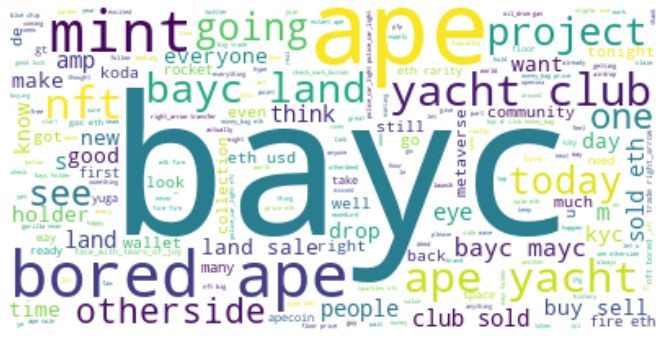

In [171]:
#Clean data
def clean_data(text):
    text=re.sub(r'@[A-Za-z0-9]+','',text)#Remove mention
    text=re.sub(r'[A-Za-z0-9]@+','',text)
    text=re.sub(r'#[A-Za-z0-9]+','',text) #Remove hashtag
    text=re.sub(r'RT[\s]+','',text) #Remove retweet
    text=re.sub(r'\w+:\/\/\S+','',text) #Remove hyperlink
    text=re.sub("[\.\,\!\?\:\;\-\=]", " ", text) #Remove all punctuations
    text=text.lower() #Avoid Case sensitive
    text = re.sub('[\s]+', ' ', text)# Replace multiple white space with one
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) #Misspelling
    text = ' '.join(((emoji.demojize(text)).replace(":"," ")).split())
    return text

def convert_contraction(tweet):
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    tweet = " ".join(reformed)
    return tweet

def convert_emoticons(text):
    SMILEY = EMOTICONS_EMO
    words = text.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    text = " ".join(reformed)
    return text

#Duplicate and NAN
def drop_duplicate(data):
    data=data.drop_duplicates(subset=['content'],keep='first',inplace=True)
def drop_na(data):
    data=data.dropna(axis=0,subset=['content'],inplace=True)
    
#Stop words
sw = stopwords.words('english') #you can adjust the language as you desire
sw.remove("not")
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in sw]
    return (" ").join(tokens_without_sw)
    
tweets_df2.rename(columns={"Text":"content"},inplace=True)
copy_data=tweets_df2.copy()
copy_data['content']=copy_data['content'].apply(clean_data)
copy_data['content']=copy_data['content'].apply(convert_emoticons)
copy_data['content']=copy_data['content'].apply(convert_contraction)
copy_data['content']=copy_data['content'].apply(remove_stopwords)
drop_duplicate(copy_data)
drop_na(copy_data)
copy_data=copy_data.drop(copy_data[copy_data.content==""].index)

fig, ax = plt.subplots(figsize=(12, 6))
all_words=' '.join([tws for tws in copy_data['content']])
wordCloud=WordCloud(random_state=21,max_font_size=119,background_color="white").generate(all_words)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.savefig('bayc.png')
plt.show()

In [172]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')
# print sentence with predicted labels
label_list=[]
for i in copy_data.index.values:
    sentence = Sentence(copy_data.content[i])
    classifier.predict(sentence)
    label_list.append(sentence.labels)

2022-05-22 23:04:43,493 loading file /Users/coppersa/.flair/models/sentiment-en-mix-distillbert_4.pt


2466
2130
0.9917566478252411
0.9777508080005646
-9.774817560526865


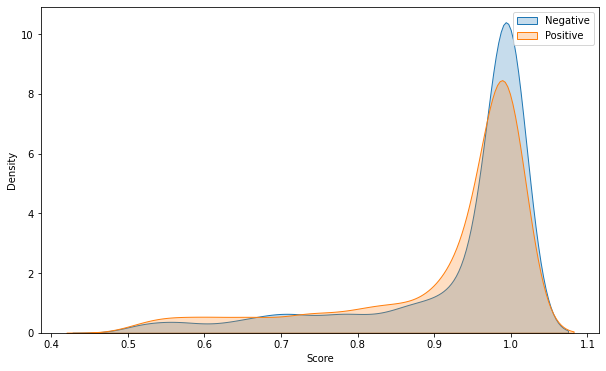

In [98]:
score_list=[]
value_list=[]
for i in range(len(label_list)):
    score_list.append(label_list[i][0].score)
    value_list.append(label_list[i][0].value)
stat_dict={"Sentiment":value_list,"Score":score_list}
stat=pd.DataFrame(stat_dict)
# stat.loc[stat.Sentiment=='NEGATIVE','Score']=-stat['Score']
fig, ax = plt.subplots(figsize=(10, 6))
negative_score=stat.loc[stat.Sentiment=="NEGATIVE",'Score']
positive_score=stat.loc[stat.Sentiment=="POSITIVE",'Score']
print(negative_score.shape[0])
print(positive_score.shape[0])
print(np.median(negative_score))
print(np.median(positive_score))
index=-np.median(negative_score)/negative_score.shape[0]+np.median(positive_score)/positive_score.shape[0]
print(np.log(index))
sns.kdeplot(negative_score,shade=True,label='Negative')
sns.kdeplot(positive_score,shade=True,label='Positive')
ax.legend()
plt.show()

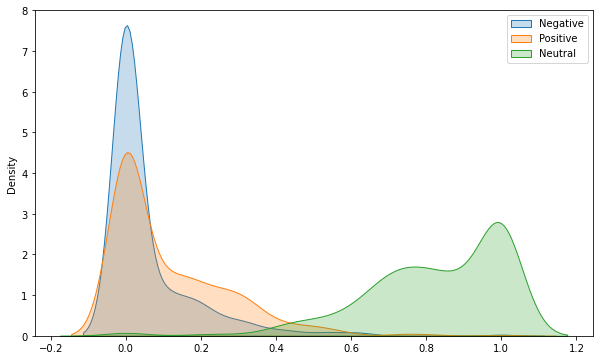

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg'], " Negative")
    print("sentence was rated as ", sentiment_dict['neu'], " Neutral")
    print("sentence was rated as ", sentiment_dict['pos'], " Positive")
    print("Sentence Overall Rated As", end = " ")
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
    else :
        print("Neutral")
neg_score=[]
pos_score=[]
neu_score=[]
for i in copy_data.index.values:
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(copy_data.content[i])
    sentiment_dict['neg']
    neg_score.append(sentiment_dict['neg'])
    pos_score.append(sentiment_dict['pos'])
    neu_score.append(sentiment_dict['neu'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(neg_score,shade=True,label='Negative')
sns.kdeplot(pos_score,shade=True,label='Positive')
sns.kdeplot(neu_score,shade=True,label="Neutral")
ax.legend()
plt.show()

![Bayc_Floor.png](./data/Bayc_Floor.png)